In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
DATA_DIR = '../data'
LOO_DIR = f'{DATA_DIR}/leaveoneout_results'
BURDEN_DIR = f'{DATA_DIR}/burdentest_erythroids'

# NOTE: K562_erythroid_rarevars_footprints_dedup.csv is not in this repo.
# It was originally at ./K562_erythroid_rarevars_footprints_dedup.csv (relative to notebook/)
erythroid_all_sigfp = pd.read_csv(f'{LOO_DIR}/K562_erythroid_rarevars_footprints_dedup.csv')
carray_df = pd.read_excel(f'{LOO_DIR}/K562_foodie_carray-20251117.xlsx', sheet_name='rare_site_carray')
var_carriers = carray_df.groupby('site')['IID'].count().reset_index().rename(columns={'IID':'#carriers'})

In [4]:
# carray_df

In [2]:
# carray_df[carray_df['site'] == 'DRAGEN:chr7:100125932:A:C'].count()

In [3]:
# carray_df[carray_df['site'] == 'DRAGEN:chr7:100125932:A:C'].sum()

In [5]:
# from matplotlib_venn import venn2
# var1_carriers = set(carray_df[carray_df['site'] == 'DRAGEN:chr7:100125929:GT:G']['IID'])
# var2_carriers = set(carray_df[carray_df['site'] == 'DRAGEN:chr7:100125932:A:C']['IID'])
# plt.figure(figsize=(6,6))
# venn2([var1_carriers, var2_carriers], set_labels = ('DRAGEN:chr7:100125929:GT:G    ', '    DRAGEN:chr7:100125932:A:C'))
# plt.title('Carriers overlapping of variants')
# plt.tight_layout()
# plt.savefig('carriers_overlap.png', dpi=300, transparent=True)

In [3]:
# NOTE: K562_rareVar_sig_annot.csv was originally at ../FOODIE_20250407/fpGWAS_varBridge_results/
# It is not in this repo. Update path if you have it locally.
K562_rareVars = pd.read_csv(f'{DATA_DIR}/results/K562_rareVar_sig_annot.csv')

In [4]:
K562_rareVars['footprint_type'].nunique()

53

In [5]:
K562_rareVars[K562_rareVars['Trait'] == 'MCV']['footprint_type'].nunique()

14

In [6]:
K562_rareVars = pd.read_csv(f'{DATA_DIR}/results/K562_rareVar_sig_annot.csv')
erythroid_traits = K562_rareVars[K562_rareVars['Type']=='Erythroid'].reset_index(drop=True)['Trait'].unique().tolist()
trait_rarefp_valid = []
trait_rareloo_valid = []
for trait in tqdm(erythroid_traits):
    rarevar_burden = pd.read_excel(f'{BURDEN_DIR}/{trait}.K562_FOODIE_fps_rare_var_result.2025-05-29.xlsx')
    carray_df = pd.read_excel(f'{LOO_DIR}/K562_foodie_carray-20251117.xlsx', sheet_name='rare_site_carray')
    trait_carray = carray_df[['site', 'GT', 'foodie', trait]].groupby('site')[[trait]].sum().reset_index().rename(columns={trait: '#carriers'})
    trait_sigfp_carries = erythroid_all_sigfp.merge(trait_carray, left_on='SNP', right_on='site').merge(rarevar_burden, left_on='Name_foodie', right_on='ID')
    trait_sigfp_carries['max_n_carriers_per_fp'] = trait_sigfp_carries.groupby('Name_foodie')['#carriers'].transform('max')
    trait_sigfp_carries_valid = trait_sigfp_carries[(trait_sigfp_carries['max_n_carriers_per_fp']>30)&(trait_sigfp_carries['p_regenie']<0.05/188484)].reset_index(drop=True)
    trait_sigfp_carries_valid['trait'] = trait
    fp_list = list(trait_sigfp_carries_valid['Name_foodie'].unique())
    rarevar_burden_sig = rarevar_burden[rarevar_burden['ID'].isin(fp_list)].reset_index(drop=True)
    rarevar_burden_sig['trait'] = trait
    trait_rarefp_valid.append(rarevar_burden_sig)
trait_valid_fp_df = pd.concat(trait_rarefp_valid).reset_index(drop=True)

100%|██████████| 13/13 [02:17<00:00, 10.59s/it]


In [ ]:
# FIG_DIR = '../results/figures/rarevar_loo'
# import os
# os.makedirs(FIG_DIR, exist_ok=True)

# for trait in erythroid_traits:
#     trait_vars = trait_valid_fp_df[trait_valid_fp_df['trait']==trait].reset_index(drop=True)
#     fp_list = trait_vars['ID'].tolist()
#     # NOTE: K562.leave_one_out.20251117.xlsx is not in this repo.
#     # The all-traits CSV is at data/leaveoneout_results/K562.leave_one_out.all_traits.20251120.csv
#     trait_loo = pd.read_excel(f'{LOO_DIR}/K562.leave_one_out.20251117.xlsx', sheet_name=trait)
#     n = len(fp_list)
#     print(trait, n)
#     ncols = 3
#     nrows = int(np.ceil(n / ncols))

#     fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 10*nrows), squeeze=False)

#     for i, fp_id in enumerate(fp_list):
#         r, c = divmod(i, ncols)
#         ax = axes[r, c]
#         mlog10p_fp = trait_vars[trait_vars['ID'] == fp_id]['LOG10P'].values[0]
#         if fp_id not in trait_loo['foodie'].values:
#             continue
#         trait_fp_loo = trait_loo[trait_loo['foodie'] == fp_id].reset_index(drop=True)
#         trait_fp_loo = trait_fp_loo.merge(var_carriers[['site', '#carriers']], left_on='ID_rare', right_on='site')

#         sns.scatterplot(
#             data=trait_fp_loo,
#             x='ID_rare',
#             y='LOG10P',
#             size='#carriers',
#             ax=ax
#         )

#         ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#         ax.axhline(y=mlog10p_fp, color='red', linestyle='--', linewidth=0.5)
#         ax.axhline(y=-np.log10(0.05/188484), color='blue', linestyle='--', linewidth=0.5)
#         ax.text(0.95, 0.5, f'Footprint burden test -log10(pvalue): {mlog10p_fp:.2f}', transform=ax.transAxes, ha='right', va='top', fontsize=10, color='red')
#         ax.grid(linewidth=0.5, linestyle='--', alpha=0.3)
#         ax.set_title(f'{fp_id}')
#         ax.set_xlabel('')

#     for j in range(i+1, nrows*ncols):
#         r, c = divmod(j, ncols)
#         fig.delaxes(axes[r, c])

#     fig.tight_layout(rect=[0, 0, 1, 0.97])
#     fig.suptitle(
#         'Leave-One-Out Analysis for Significant Footprints (Trait: {})'.format(trait),
#         y=0.98,
#         fontsize=16
#     )
#     plt.savefig(f'{FIG_DIR}/{trait}_rare_loo.pdf', transparent=True)

In [ ]:
# K562_rareVars['footprint_type']

In [8]:
trait_valid_fp_df[trait_valid_fp_df['trait']=='MCV'].reset_index(drop=True)

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,p_regenie,MAC,trait
0,16,234780,chr16:234776-234784,A,True,0.000603,1,469410,ADD,-0.767935,0.038343,401.1150,88.50180,NaN,3.149198e-89,566,MCV
1,16,234815,chr16:234807-234822,A,True,0.000664,1,469410,ADD,-0.700174,0.036396,370.0860,81.74660,NaN,1.792256e-82,623,MCV
2,16,234848,chr16:234844-234852,A,True,0.000835,1,469410,ADD,-0.563771,0.032349,303.7270,67.29410,NaN,5.080424e-68,784,MCV
3,16,180731,chr16:180724-180738,A,True,0.000355,1,469410,ADD,-0.628091,0.049313,162.2300,36.43350,NaN,3.685530e-37,333,MCV
4,16,173005,chr16:172995-173014,A,True,0.000088,1,469410,ADD,-1.239120,0.097882,160.2600,36.00320,NaN,9.926588e-37,83,MCV
5,16,589103,chr16:589088-589118,A,True,0.000540,1,469410,ADD,-0.343852,0.039818,74.5743,17.23360,NaN,5.839827e-18,507,MCV
6,16,318854,chr16:318844-318863,A,True,0.000300,1,469410,ADD,-0.459657,0.053668,73.3553,16.96540,NaN,1.082929e-17,282,MCV
7,16,622318,chr16:622303-622332,A,True,0.000373,1,469410,ADD,-0.396784,0.047842,68.7834,15.95900,NaN,1.099006e-16,350,MCV
8,16,145025,chr16:145010-145040,A,True,0.000811,1,469410,ADD,-0.246094,0.033921,52.6325,12.39560,NaN,4.021610e-13,761,MCV
9,6,27132004,chr6:27131998-27132010,A,True,0.000668,1,469410,ADD,0.240452,0.036500,43.3977,10.35000,NaN,4.466836e-11,627,MCV


In [13]:
def plot_loo(trait, fp_id):
    figure, ax = plt.subplots(figsize=(6, 5))
    trait_vars = trait_valid_fp_df[trait_valid_fp_df['trait']==trait].reset_index(drop=True)
    trait_loo = pd.read_excel(f'{LOO_DIR}/K562.leave_one_out.20251117.xlsx', sheet_name=trait)
    mlog10p_fp = trait_vars[trait_vars['ID'] == fp_id]['LOG10P'].values[0]
    trait_fp_loo = trait_loo[trait_loo['foodie'] == fp_id].reset_index(drop=True)
    trait_fp_loo['Loo_effect'] = (trait_fp_loo['LOG10P'] - mlog10p_fp)>=0
    trait_fp_loo = trait_fp_loo.merge(var_carriers[['site', '#carriers']], left_on='ID_rare', right_on='site')
    trait_fp_loo['ID_rare'] = trait_fp_loo['ID_rare'].str.replace('DRAGEN:', '')
    trait_fp_loo = trait_fp_loo.sort_values(by='GENPOS', ascending=True).reset_index(drop=True)
    sns.scatterplot(
            data=trait_fp_loo,
            y='ID_rare',
            x='LOG10P',
            size='#carriers',
            sizes=(50, 100),
        )
    plt.axvline(x=mlog10p_fp, color='red', linestyle='--', linewidth=1, alpha=0.8)
    plt.axvline(x=-np.log10(0.05/188484), linestyle='--', linewidth=1, alpha=0.8)
    plt.grid(linewidth=1, linestyle='--', alpha=0.2)
    plt.xlabel('-log10(p-value)')
    plt.margins(y=0.02)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='#Carriers')
    plt.ylabel(f'{fp_id}')

    plt.tight_layout()
    return trait_fp_loo
    # plt.savefig(f'{FIG_DIR}/{trait}_{fp_id.replace(":", "_")}_footprint_loo.pdf', bbox_inches='tight', transparent=True)

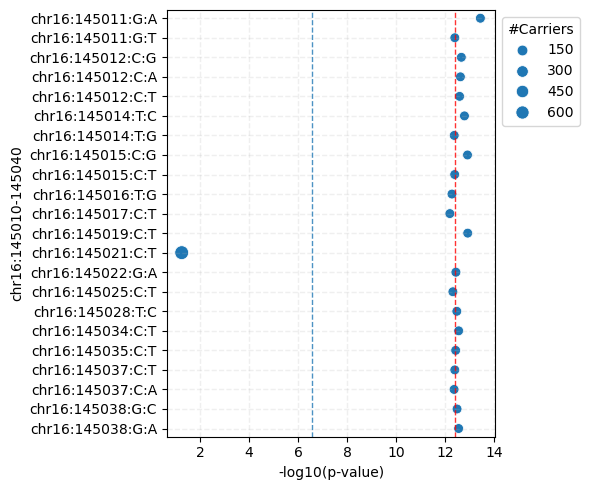

In [15]:
fp_trait_loo = plot_loo('MCV','chr16:145010-145040')

In [16]:
fp_trait_loo

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,...,SE_rare,CHISQ_rare,LOG10P_rare,EXTRA_rare,p_regenie_rare,mask_rare,MAC_rare,Loo_effect,site,#carriers
0,16,145011,rm:DRAGEN:chr16:145011:G:A,A,G,0.000795,1,469395,ADD,-0.259605,...,0.229994,2.486650,0.939997,NaN,1.148162e-01,rare_K562,15.0,True,DRAGEN:chr16:145011:G:A,16
1,16,145011,rm:DRAGEN:chr16:145011:G:T,A,G,0.000810,1,469409,ADD,-0.246151,...,0.889971,0.054357,0.088497,NaN,8.156486e-01,rare_K562,1.0,False,DRAGEN:chr16:145011:G:T,1
2,16,145012,rm:DRAGEN:chr16:145012:C:G,A,G,0.000808,1,469408,ADD,-0.249141,...,0.629297,1.620990,0.692601,NaN,2.029546e-01,rare_K562,2.0,True,DRAGEN:chr16:145012:C:G,2
3,16,145012,rm:DRAGEN:chr16:145012:C:A,A,G,0.000810,1,469409,ADD,-0.248566,...,0.889963,2.675410,0.991787,NaN,1.019091e-01,rare_K562,1.0,True,DRAGEN:chr16:145012:C:A,1
4,16,145012,rm:DRAGEN:chr16:145012:C:T,A,G,0.000810,1,469409,ADD,-0.248207,...,0.890016,1.847660,0.759312,NaN,1.740556e-01,rare_K562,1.0,True,DRAGEN:chr16:145012:C:T,1
5,16,145014,rm:DRAGEN:chr16:145014:T:C,A,G,0.000805,1,469405,ADD,-0.250727,...,0.398385,1.366930,0.615575,NaN,2.423399e-01,rare_K562,5.0,True,DRAGEN:chr16:145014:T:C,5
6,16,145014,rm:DRAGEN:chr16:145014:T:G,A,G,0.000810,1,469409,ADD,-0.245904,...,0.889957,0.180421,0.173270,NaN,6.710116e-01,rare_K562,1.0,False,DRAGEN:chr16:145014:T:G,1
7,16,145015,rm:DRAGEN:chr16:145015:C:G,A,G,0.000808,1,469408,ADD,-0.251674,...,0.629394,7.518270,2.214130,NaN,6.107592e-03,rare_K562,2.0,True,DRAGEN:chr16:145015:C:G,3
8,16,145015,rm:DRAGEN:chr16:145015:C:T,A,G,0.000810,1,469409,ADD,-0.246096,...,0.890025,0.074067,0.104851,NaN,7.855051e-01,rare_K562,1.0,False,DRAGEN:chr16:145015:C:T,1
9,16,145016,rm:DRAGEN:chr16:145016:T:G,A,G,0.000810,1,469409,ADD,-0.244923,...,0.889955,1.396690,0.624740,NaN,2.372794e-01,rare_K562,1.0,False,DRAGEN:chr16:145016:T:G,1


In [ ]:
# K562_rareVars 